In [1]:
import numpy as np
import pandas as pd 
import fbprophet 
from fbprophet import Prophet
import plotly
import statsmodels
from statsmodels.tsa.stattools import acf
from matplotlib import pyplot
import altair as alt
import scipy
from scipy import signal
import spectrum 
from spectrum import WelchPeriodogram
from spectrum import Periodogram
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import q_stat
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.tsa.stattools import arma_order_select_ic
from statsmodels.tsa.seasonal import STL
import statsmodels.api as sm
from math import sqrt
import warnings
from statsmodels.tsa.stattools import kpss
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

In [2]:
flu_data = pd.read_csv('flu.csv', header = 2, sep = ',')

In [3]:
flu_data.head(n=5)

,Country,WHOREGION,FLUREGION,Year,Week,SDATE,EDATE,SPEC_RECEIVED_NB,SPEC_PROCESSED_NB,AH1,...,AH5,ANOTSUBTYPED,INF_A,BYAMAGATA,BVICTORIA,BNOTDETERMINED,INF_B,ALL_INF,ALL_INF2,TITLE
0,United States of America,Region of the Americas of WHO,North America,2013,1,2012-12-31,2013-01-06,18219,18219,0.0,...,0.0,1653,5377,0,0,1097,1097,6474,NaN,Widespread Outbreak
1,United States of America,Region of the Americas of WHO,North America,2013,2,2013-01-07,2013-01-13,20013,20013,0.0,...,0.0,1767,5752,0,0,1145,1145,6897,NaN,Widespread Outbreak
2,United States of America,Region of the Americas of WHO,North America,2013,3,2013-01-14,2013-01-20,19228,19228,0.0,...,0.0,1624,4858,0,0,1078,1078,5936,NaN,Widespread Outbreak
3,United States of America,Region of the Americas of WHO,North America,2013,4,2013-01-21,2013-01-27,17139,17139,0.0,...,0.0,1528,4039,0,0,1091,1091,5130,NaN,Widespread Outbreak
4,United States of America,Region of the Americas of WHO,North America,2013,5,2013-01-28,2013-02-03,14795,14795,0.0,...,0.0,951,2963,0,0,1076,1076,4039,NaN,Widespread Outbreak


## Utility Functions

### Adapted from 

###### https://www.statsmodels.org/devel/examples/notebooks/generated/statespace_forecasting.html
###### https://www.statsmodels.org/stable/examples/notebooks/generated/stl_decomposition.html
###### https://www.statsmodels.org/stable/examples/notebooks/generated/stationarity_detrending_adf_kpss.html
###### https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html
###### https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_fixed_params.html
###### https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/


In [4]:
def arima_window_ase(data_series, train_ratio = .60, order = (0,0,0)): 
    X_series = data_series.values
    size = int(len(X_series)*train_ratio)
    train,test = X_series[0:size], X_series[size:len(X_series)]
    history = [i for i in train]
    preds = list()
    for t in range(len(test)): 
        model = ARIMA(history, order=order)
        model_fit = model.fit()
        fore_cast = model_fit.forecast()
        yhat = fore_cast[0]
        preds.append(yhat)
        obs = test[t]
        history.append(obs)
    rmse = sqrt(mean_squared_error(test, preds))
    pyplot.plot(test)
    pyplot.plot(preds, color='red')
    pyplot.show()
    
    return rmse
    print(residuals.describe())

In [5]:
def arima_seas_window_ase(data_series, train_ratio = .60, order = (0,0,0), seasonal_order = (0,0,0,0),simple_differencing=True): 
    X_series = data_series.values
    size = int(len(X_series)*train_ratio)
    train,test = X_series[0:size], X_series[size:len(X_series)]
    history = [i for i in train]
    preds = list()
    for t in range(len(test)): 
        model = ARIMA(history, order=order)
        model = sm.tsa.statespace.SARIMAX(history, order=order, seasonal_order=seasonal_order,simple_differencing=simple_differencing) 
        model_fit = model.fit()
        fore_cast = model_fit.forecast()
        yhat = fore_cast[0]
        preds.append(yhat)
        obs = test[t]
        history.append(obs)
    rmse = sqrt(mean_squared_error(test, preds))
    pyplot.plot(test)
    pyplot.plot(preds, color='red')
    pyplot.show()
    
    return rmse
    print(residuals.describe())

In [6]:
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [7]:
def make_realization(data_frame,x,y): 
    
    vis = alt.Chart(data_frame).mark_line().encode(
    x = x, 
    y = y
    )
    
    return vis

In [8]:
def make_autocorr(data_series, nlags=40, fft = False): 
    auto_corr = statsmodels.tsa.stattools.acf(data_series, nlags=nlags, fft=fft)
    data = pd.DataFrame(list(enumerate(auto_corr)), columns = ['Lag', 'AutoCor'])
    vis = alt.Chart(data).mark_bar().encode(
    x='Lag',
    y='AutoCor',
    )
    return vis

In [9]:
def make_sig_periodgram(data_series, fs = 1, scaling = 'density'): 
    f, Pxx_den = scipy.signal.periodogram(data_series, fs = fs, scaling=scaling)
    data = pd.DataFrame({'Freq' : f,'Density' : Pxx_den})
    vis = alt.Chart(data).mark_bar().encode(
        x='Freq',
        y='Density',
    )
    return vis

In [10]:
def make_welch_sig_periodgram(data_series, fs = 1, nperseg=50): 
    f, Pxx_den = scipy.signal.welch(flu_data.SPEC_RECEIVED_NB, fs = 1, nperseg=nperseg)
    data = pd.DataFrame({'Freq' : f,'Density' : Pxx_den})
    vis = alt.Chart(data).mark_bar().encode(
        x='Freq',
        y='Density',
    )
    return vis

In [11]:
def make_welch_periodgram(data_series, sampling = 50):
    psd = WelchPeriodogram(data_series, sampling)
    return psd[1]

### Function call to realization generations

In [12]:
make_realization(flu_data, 'EDATE:T', 'SPEC_RECEIVED_NB')

alt.Chart(...)

### Under the hood this is what the make_realization function does

In [13]:
alt.Chart(flu_data).mark_line().encode(
    x='EDATE:T',
    y='SPEC_RECEIVED_NB'
)


alt.Chart(...)

### To verify if variable is a series 

In [14]:
series = flu_data.SPEC_RECEIVED_NB
series.index

RangeIndex(start=0, stop=423, step=1)

### Function call to generate autocorrelation plot
### we can see there is evidence against stationarity, there is slowly dampening sinusiodal autocorrelations

In [15]:
make_autocorr(flu_data.SPEC_RECEIVED_NB, nlags = 40)

alt.Chart(...)

### KPSS test

###### KPSS is another test for checking the stationarity of a time series. The null and alternate hypothesis for the KPSS test are opposite that of the ADF test.

##### H0: The process is trend stationary.

##### Ha: The series has a unit root (series is not stationary).

### There is sufficient evidence to suggest this process is not stationary (pvalue < 0.05)

In [16]:
kpss_test(flu_data.SPEC_RECEIVED_NB)

Results of KPSS Test:
Test Statistic            0.956315
p-value                   0.010000
Lags Used                12.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/home/andrew/Documents/qtw/env/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


### Under the hood this is what the make_autocorr function does

In [17]:
SPEC_RECIEVD_NB_auto_cor = statsmodels.tsa.stattools.acf(flu_data.SPEC_RECEIVED_NB)

/home/andrew/Documents/qtw/env/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:662: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  FutureWarning,
/home/andrew/Documents/qtw/env/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


In [18]:
data = pd.DataFrame(list(enumerate(SPEC_RECIEVD_NB_auto_cor)), columns = ['Lag', 'AutoCor'])
alt.Chart(data).mark_bar().encode(
    x='Lag',
    y='AutoCor',
)

alt.Chart(...)

### Make function call to series periodgram to see if underlying frequency exists

In [19]:
make_sig_periodgram(flu_data.SPEC_RECEIVED_NB)

alt.Chart(...)

### ### Under the hood this is what the make_sig_periodgram function does

In [20]:
f, Pxx_den = scipy.signal.periodogram(flu_data.SPEC_RECEIVED_NB, fs = 1, scaling='density')

In [21]:
data = pd.DataFrame({'Freq' : f,'Density' : Pxx_den})
alt.Chart(data).mark_bar().encode(
    x='Freq',
    y='Density',
)

alt.Chart(...)

### make function call to make_welch_sig_perdiogram function

In [22]:
make_welch_sig_periodgram(flu_data.SPEC_RECEIVED_NB, fs = 1, nperseg=420)

alt.Chart(...)

### Under the hood this is what the make_realization function does

In [23]:
f, Pxx_den = scipy.signal.welch(flu_data.SPEC_RECEIVED_NB, fs = 1, nperseg=420)

In [24]:
data = pd.DataFrame({'Freq' : f,'Density' : Pxx_den})
alt.Chart(data).mark_bar().encode(
    x='Freq',
    y='Density',
)

alt.Chart(...)

### function call to welch Power Spectral Density plot function 
### There appears to be a period of 40 weeks, 1/.025. 

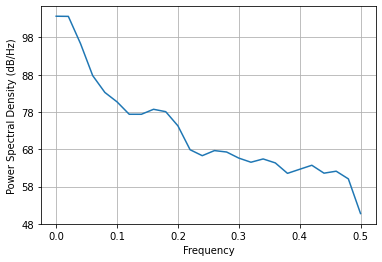

In [25]:
make_welch_periodgram(flu_data.SPEC_RECEIVED_NB,sampling = 50)

### Under the hood this is what the make_welch_periodgram function does

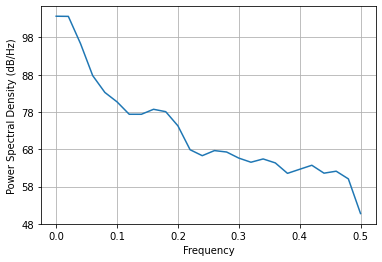

In [26]:
psd = WelchPeriodogram(flu_data.SPEC_RECEIVED_NB,50)

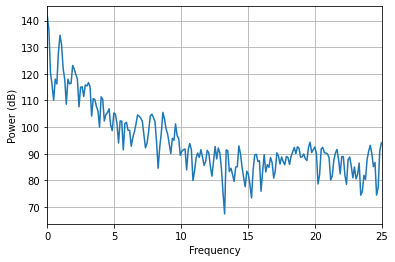

In [27]:
psd = Periodogram(flu_data.SPEC_RECEIVED_NB, 50, scale_by_freq = True)
psd.plot()

#### Let's difference by the 40 week factor

In [28]:
dif_40 = statsmodels.tsa.statespace.tools.diff(flu_data.SPEC_RECEIVED_NB,k_diff=0, k_seasonal_diff=40, seasonal_periods=1 )
dif_40

40     1.754897e+13
41    -2.316631e+13
42     2.328478e+13
43    -1.886322e+13
44     1.198487e+13
           ...     
418    1.216876e+14
419   -2.269202e+14
420    3.497979e+14
421   -4.620730e+14
422    5.289912e+14
Name: SPEC_RECEIVED_NB, Length: 383, dtype: float64

### We can see there is almost cyclical behavior in the autocorrelations, but the autocorrelations dampen more quickly to nearly stationary. 

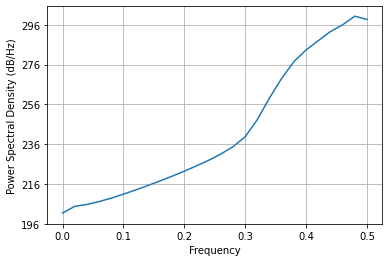

In [29]:
make_welch_periodgram(dif_40.values,sampling = 50)

In [30]:
make_autocorr(dif_40.values, nlags = 40)

alt.Chart(...)

### KPSS test

###### KPSS is another test for checking the stationarity of a time series. The null and alternate hypothesis for the KPSS test are opposite that of the ADF test.

##### H0: The process is trend stationary.

##### Ha: The series has a unit root (series is not stationary).

#### There is not sufficient evidence to suggest after differencing the process is not stationary. (pvalue > 0.05). 

In [31]:
kpss_test(dif_40)

Results of KPSS Test:
Test Statistic            0.056988
p-value                   0.100000
Lags Used                21.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/home/andrew/Documents/qtw/env/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


#### We can see there is evidence of an underlying Seasonality and positive trend. 

In [32]:
series = pd.Series(flu_data.SPEC_RECEIVED_NB.values, index = flu_data.EDATE.astype('datetime64[ns]'), name = "Seasonal_Series")
series.describe()

count      423.000000
mean     21310.659574
std      19085.596324
min       1968.000000
25%       7114.000000
50%      14583.000000
75%      29508.500000
max      88743.000000
Name: Seasonal_Series, dtype: float64

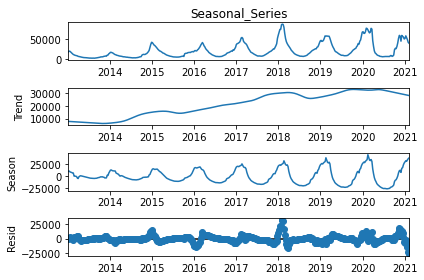

In [33]:
stl = STL(series, seasonal=41)
res = stl.fit()
fig = res.plot()

### Lets get an estimate of our arma model structure, assuming stationarity despite evidence against

In [34]:
res = statsmodels.tsa.stattools.arma_order_select_ic(flu_data.SPEC_RECEIVED_NB, ic=["aic", "bic"], trend="nc")

/home/andrew/Documents/qtw/env/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/andrew/Documents/qtw/env/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA an

In [35]:
res.aic

,0,1,2
0,NaN,9340.380969,8935.618407
1,8137.488407,8028.267909,7989.563702
2,7985.137073,7986.159993,7984.675115
3,7986.216854,7983.348112,7984.749204
4,7988.216563,7984.104760,7971.680217


In [36]:
res.aic_min_order

(4, 2)

In [37]:
res.bic

,0,1,2
0,NaN,9348.475713,8947.760524
1,8145.583151,8040.410025,8005.753190
2,7997.279190,8002.349482,8004.911976
3,8002.406343,8003.584973,8009.033437
4,8008.453424,8008.388994,8000.011822


In [38]:
res.bic_min_order

(2, 0)

### AIC and BIC differ, but we will go with BIC model structure, suggesting the errors are Gaussian, but maylook to be centered on zero. We see the errors still look correlated and there is some trend the model is not capturing. 

                               SARIMAX Results                                
Dep. Variable:       SPEC_RECEIVED_NB   No. Observations:                  423
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -3985.131
Date:                Sun, 21 Feb 2021   AIC                           7978.263
Time:                        08:58:02   BIC                           7994.452
Sample:                             0   HQIC                          7984.660
                                - 423                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.131e+04   8613.545      2.474      0.013    4428.421    3.82e+04
ar.L1          1.5316      0.024     65.133      0.000       1.485       1.578
ar.L2         -0.5602      0.022    -25.103      0.0

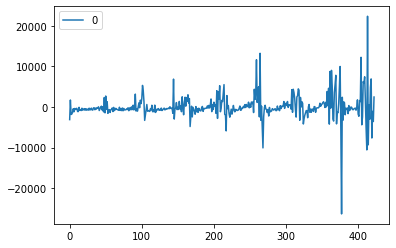

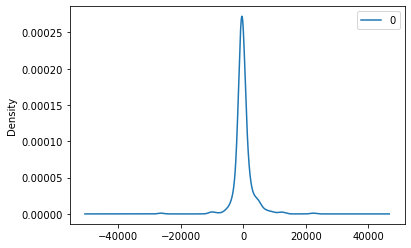

                  0
count    423.000000
mean      11.453362
std     2980.691003
min   -26331.120360
25%     -861.404582
50%     -356.491900
75%      489.911810
max    22381.314924


In [39]:
model = ARIMA(flu_data.SPEC_RECEIVED_NB, order=(2,0,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

##### H0: The data are independently distributed (i.e. the correlations in the population from which the sample is taken are 0, so that any observed correlations in the data result from randomness of the sampling process).
##### Ha: The data are not independently distributed; they exhibit serial correlation.

We can see at Lag 10 there is sufficient evidence to say the residuals are not idependently distributed, and supports serial correlation. But that does not mean the model is not useful. 

In [40]:
 sm.stats.acorr_ljungbox(model_fit.resid, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,34.945156,0.000128


### Function call to arima_window_ase
### We can see the model does follow the data well. 

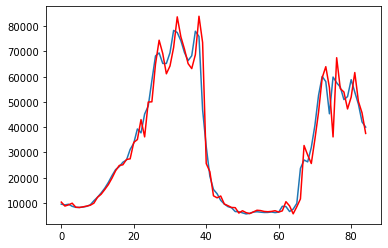

5575.032703974372

In [41]:
arima_window_ase(flu_data.SPEC_RECEIVED_NB, train_ratio = .80, order=(2,0,0))

/home/andrew/Documents/qtw/env/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/andrew/Documents/qtw/env/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/andrew/Documents/qtw/env/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


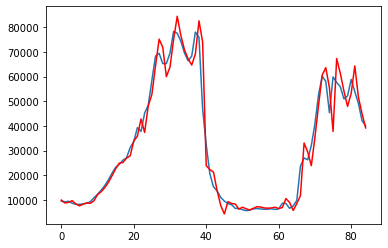

5583.778779665173

In [42]:
arima_window_ase(flu_data.SPEC_RECEIVED_NB, train_ratio = .80, order=(4,1,2))

### Under the hood this is what the arima_window_ASE does 

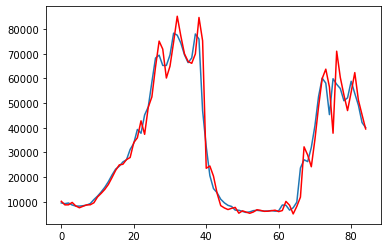

In [43]:
X = flu_data.SPEC_RECEIVED_NB.values
size = int(len(X) * 0.80)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# window MSE 
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

In [44]:
rmse

5682.187290641301

### Now lets use a seasonal factor

In [45]:
res_seas = statsmodels.tsa.stattools.arma_order_select_ic(dif_40, ic=["aic", "bic"], trend="nc")

/home/andrew/Documents/qtw/env/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/andrew/Documents/qtw/env/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA an

/home/andrew/Documents/qtw/env/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/andrew/Documents/qtw/env/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        Futur

### AIC AND BIC agree on differenced data

In [46]:
res_seas.aic_min_order

(4, 0)

In [47]:
res_seas.bic_min_order

(4, 0)

                                     SARIMAX Results                                      
Dep. Variable:                   SPEC_RECEIVED_NB   No. Observations:                  423
Model:             SARIMAX(4, 0, 0)x(1, 0, 0, 40)   Log Likelihood               -3988.983
Date:                            Sun, 21 Feb 2021   AIC                           7989.966
Time:                                    08:58:32   BIC                           8014.250
Sample:                                         0   HQIC                          7999.562
                                            - 423                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5145      0.026     57.723      0.000       1.463       1.566
ar.L2         -0.4825      0.045   

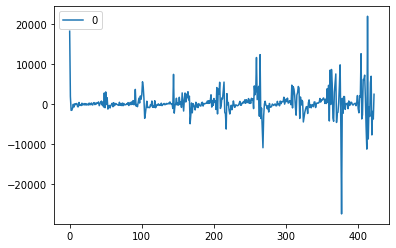

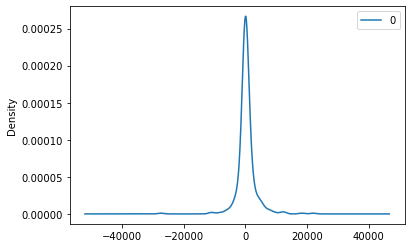

                  0
count    423.000000
mean     341.417701
std     3109.533970
min   -27375.622640
25%     -393.109826
50%      103.652384
75%      806.295958
max    21962.438195


In [48]:
mod_seas = sm.tsa.statespace.SARIMAX(flu_data.SPEC_RECEIVED_NB, order=(4,0,0), seasonal_order=(1,0,0,40), simple_differencing=True)
mod_seas_fit = mod_seas.fit()
# summary of fit model
print(mod_seas_fit.summary())
# line plot of residuals
residuals_seas = pd.DataFrame(mod_seas_fit.resid)
residuals_seas.plot()
pyplot.show()
# density plot of residuals
residuals_seas.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals_seas.describe())

H0: The data are independently distributed (i.e. the correlations in the population from which the sample is taken are 0, so that any observed correlations in the data result from randomness of the sampling process).
Ha: The data are not independently distributed; they exhibit serial correlation.

We can see at Lag 10 (pvalue < 0.05) there is sufficient evidence to say the residuals are not idependently distributed, and supports serial correlation.But that does not mean the model is not useful. 

In [49]:
 sm.stats.acorr_ljungbox(mod_seas_fit.resid, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,30.212416,0.000791


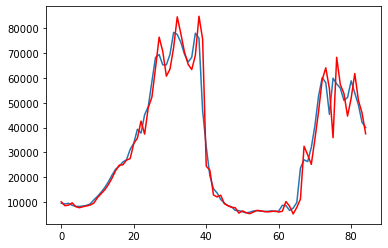

5810.365732256597

In [50]:
arima_seas_window_ase(flu_data.SPEC_RECEIVED_NB, train_ratio = .80, order = (4,0,0), seasonal_order = (1,0,0,40),simple_differencing=True)